In [ ]:
!pip install torch torchvision kagglehub tqdm scikit-learn seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import torch
import torchvision
import numpy as np
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import kagglehub
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.calibration import calibration_curve
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the trained model
model = torch.load("/content/drive/MyDrive/ML Project/For Comparision/best_model_resnet50.pth", map_location=device, weights_only=False)

if isinstance(model, torch.nn.DataParallel):
    model = model.module

model.to(device)
model.eval()

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Download the dataset using kagglehub (adjust the dataset identifier if needed)
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
print("Dataset downloaded to:", path)
dataset_dir = os.path.join(path, "Dataset")
train_dir = os.path.join(dataset_dir, "Train")
val_dir   = os.path.join(dataset_dir, "Validation")
test_dir  = os.path.join(dataset_dir, "Test")

Dataset downloaded to: /kaggle/input/deepfake-and-real-images


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
}

In [ ]:
# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset  = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

total_loss = 0.0
all_labels = []
all_preds = []

pbar_test = tqdm(dataloaders['test'], desc="Testing Phase", leave=False)
with torch.no_grad():
    for inputs, labels in pbar_test:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape: [B, 1]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs)
        all_preds.extend(preds.cpu().numpy().flatten().tolist())
        all_labels.extend(labels.cpu().numpy().flatten().tolist())
        pbar_test.set_postfix({"Loss": f"{loss.item():.4f}"})

test_loss = total_loss / len(test_dataset)
try:
    test_auc = roc_auc_score(all_labels, all_preds)
except ValueError:
    test_auc = 0.0

print("\nOverall Test Metrics:")
print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")


Overall Test Metrics:
Test Loss: 0.4508, Test AUC: 0.9748


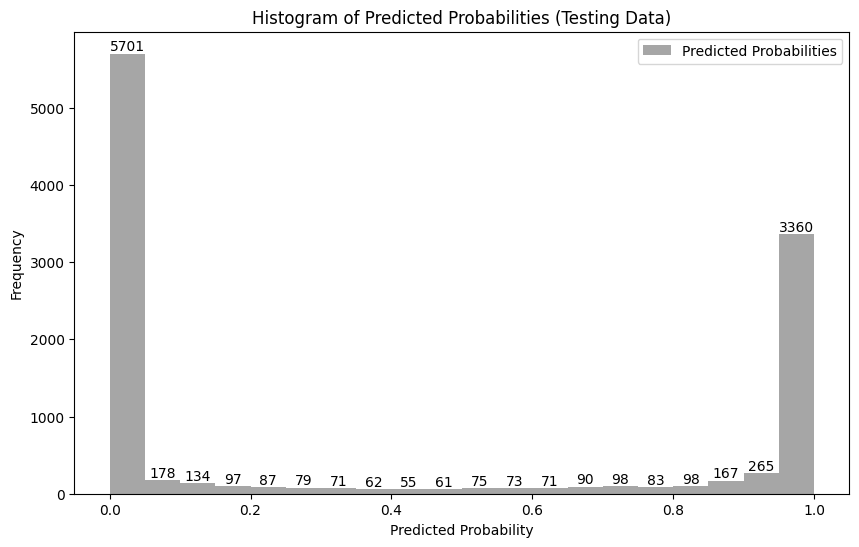

In [ ]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(all_preds, bins=20, color='gray', alpha=0.7, label='Predicted Probabilities')

# Add labels (frequency count) on each bar
for i in range(len(patches)):
    height = patches[i].get_height()
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities (Testing Data)')
plt.legend(loc='upper right')
plt.show()

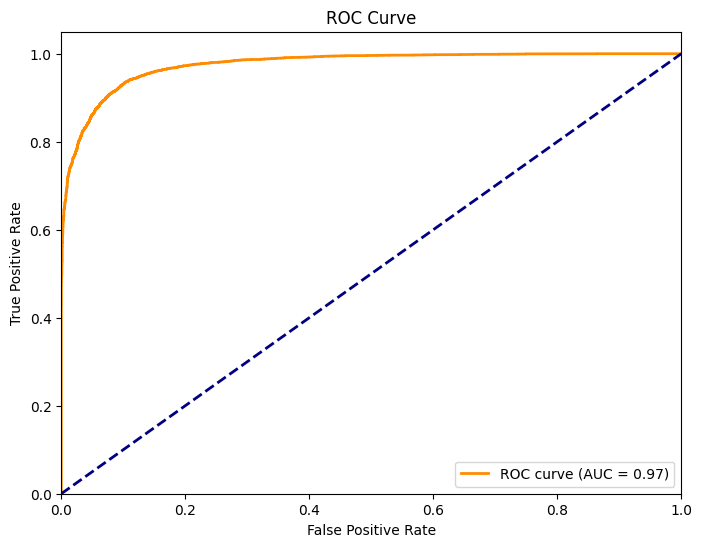

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

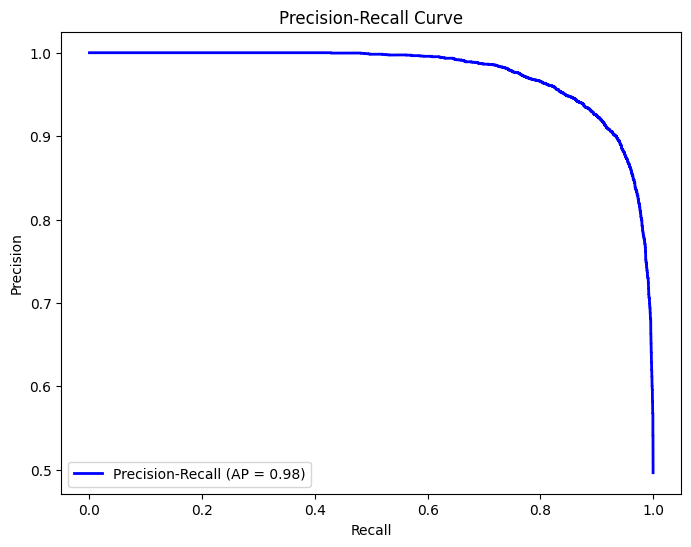

In [ ]:
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
average_precision = average_precision_score(all_labels, all_preds)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

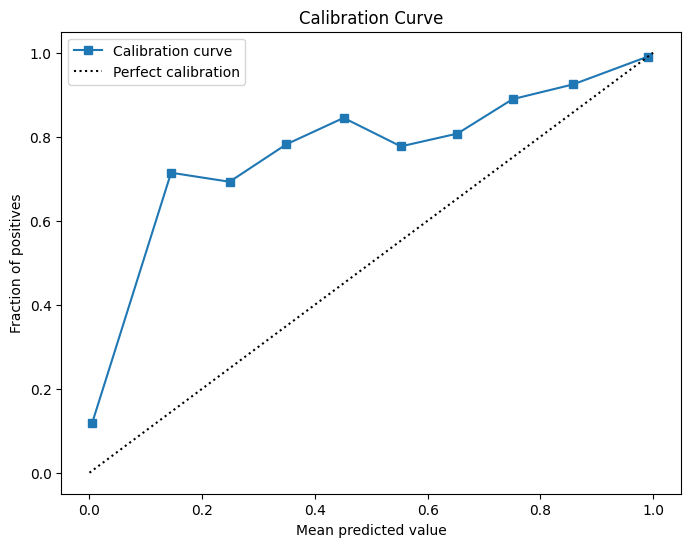

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(all_labels, all_preds, n_bins=10, strategy='uniform')

plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration curve')
plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()

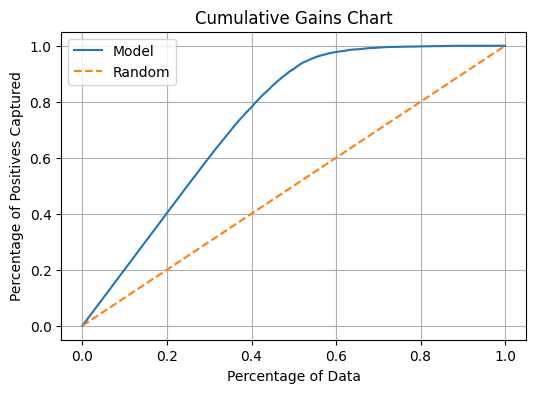

In [ ]:
df = pd.DataFrame({"label": all_labels, "pred": all_preds})
df = df.sort_values("pred", ascending=False).reset_index(drop=True)
df["cumulative_positive"] = df["label"].cumsum()
df["percentage_positive"] = df["cumulative_positive"] / df["label"].sum()
df["percentage_data"] = (df.index + 1) / len(df)

plt.figure(figsize=(6, 4))
plt.plot(df["percentage_data"], df["percentage_positive"], label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("Percentage of Data")
plt.ylabel("Percentage of Positives Captured")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.grid(True)
plt.show()


Threshold: 0.3
Test Accuracy: 0.8942


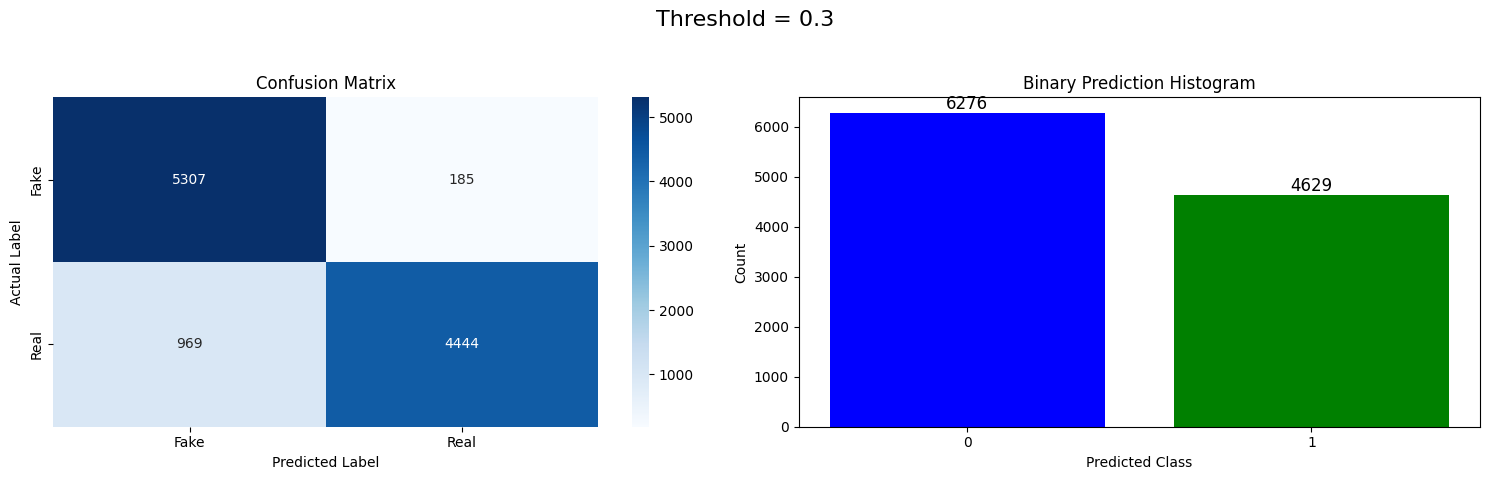


Threshold: 0.4
Test Accuracy: 0.8873


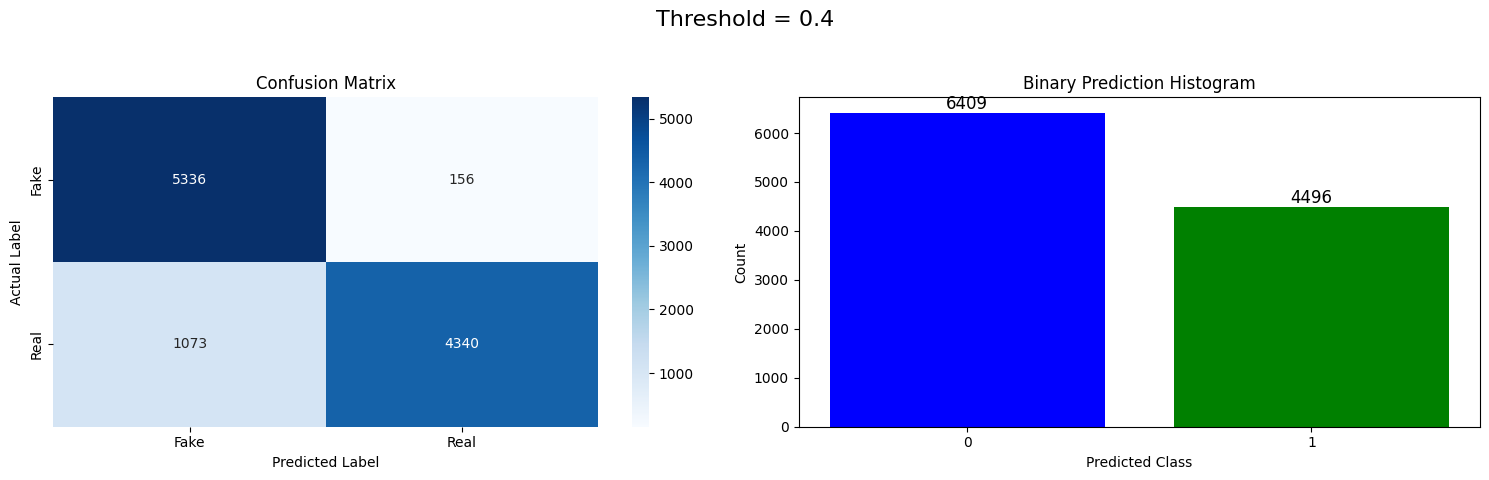


Threshold: 0.5
Test Accuracy: 0.8800


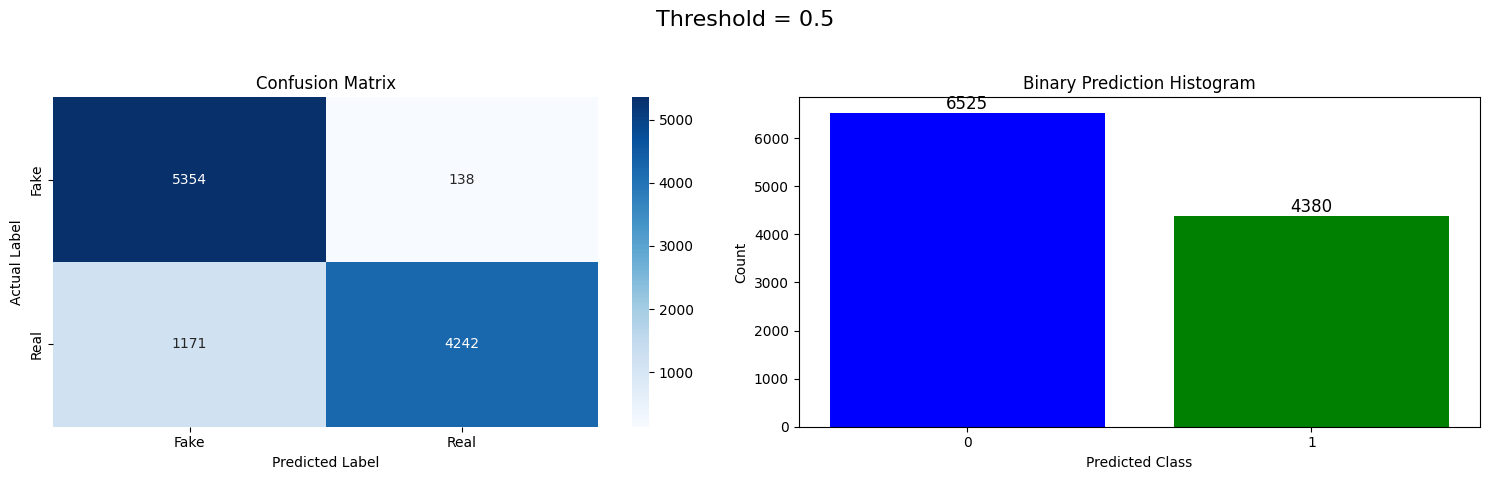


Threshold: 0.6
Test Accuracy: 0.8724


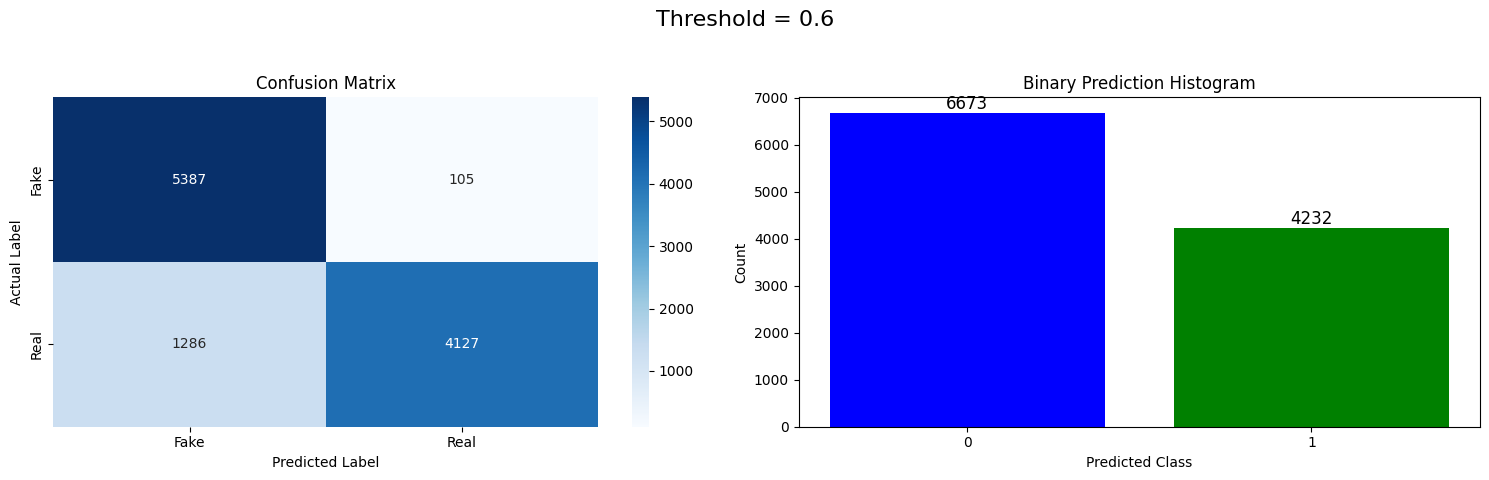


Threshold: 0.7
Test Accuracy: 0.8634


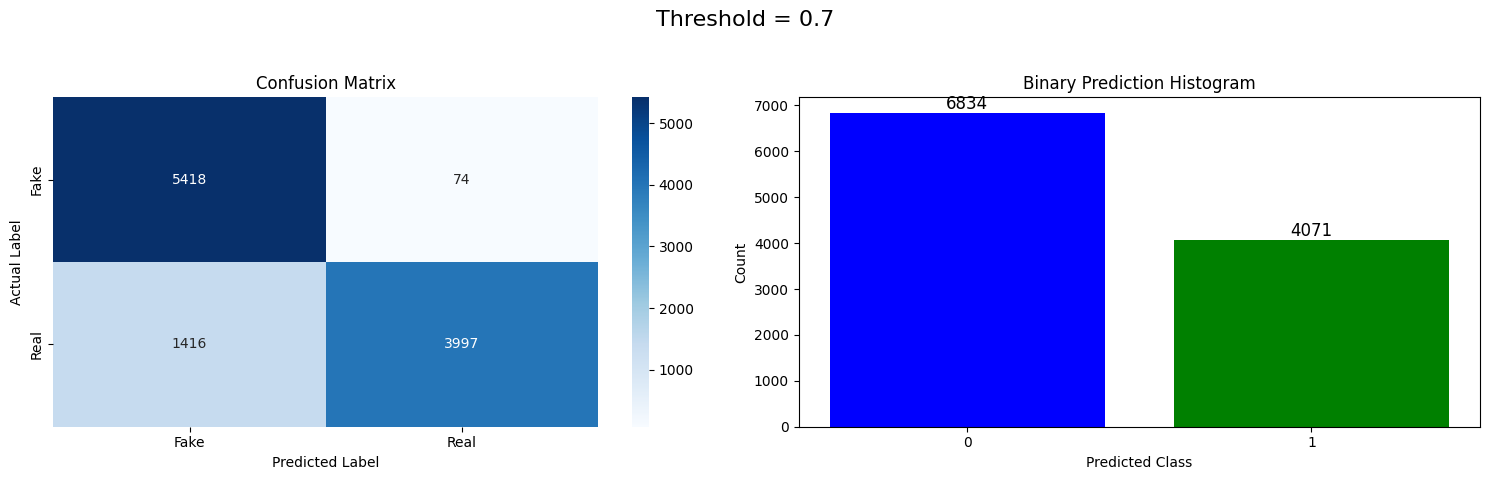

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    # Convert probabilities to binary predictions
    test_preds_labels = (np.array(all_preds) >= thresh).astype(int)
    test_labels_np = np.array(all_labels).astype(int)
    test_accuracy = (test_preds_labels == test_labels_np).mean()

    print(f"\nThreshold: {thresh}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Create a figure with 2 rows and 2 columns for organized plots (confusion matrix and binary prediction bar chart)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Threshold = {thresh}", fontsize=16)

    # Subplot 1: Confusion Matrix Heatmap
    cm = confusion_matrix(test_labels_np, test_preds_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes,
                ax=axs[0])
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('Actual Label')
    axs[0].set_title('Confusion Matrix')

    # Subplot 2: Bar Chart of Binary Predictions with Count Annotation
    unique, counts = np.unique(test_preds_labels, return_counts=True)
    axs[1].bar(unique, counts, color=['blue', 'green'])
    axs[1].set_xticks([0, 1])
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Binary Prediction Histogram')
    # Annotate each bar with its count
    for i, count in zip(unique, counts):
        axs[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
